# Kung Fu Pandas' Report
-------------------
### Authors:
Piotr Balewski \
Adam Dobosz \
Wiktor Kamzela \
Michał Redmer 

## Introduction

## Description of the dataset

## Description of the input features

## Exploratory Analysis of the input features

## Preprocessing techniques used in the assignment
### Description
### Motivation

## Description of the output features 

## Exploratory analysis of the output features

Conclusions

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
data = pd.read_csv('CarsData.csv')

In [3]:
print(data.head())

           model  year  price transmission  mileage fuelType  tax   mpg  \
0            I10  2017   7495       Manual    11630   Petrol  145  60.1   
1           Polo  2017  10989       Manual     9200   Petrol  145  58.9   
2       2 Series  2019  27990    Semi-Auto     1614   Diesel  145  49.6   
3   Yeti Outdoor  2017  12495       Manual    30960   Diesel  150  62.8   
4         Fiesta  2017   7999       Manual    19353   Petrol  125  54.3   

   engineSize Manufacturer  
0         1.0       hyundi  
1         1.0   volkswagen  
2         2.0          BMW  
3         2.0        skoda  
4         1.2         ford  


In [4]:
for col in data.columns:
    # print number of nan values
    print(col, data[col].isnull().sum())

model 0
year 0
price 0
transmission 0
mileage 0
fuelType 0
tax 0
mpg 0
engineSize 0
Manufacturer 0


In [8]:
print(data.model.nunique())

196


In [18]:
# print only values of model column that constitue over 1% of the data
models_over_1percent = data.model.value_counts(normalize=True)[data.model.value_counts(normalize=True) > 0.01]
# sum of all values that are over 1%
print(models_over_1percent.sum())

0.6588852955624692


In [19]:
print(models_over_1percent)

model
 Fiesta      0.066614
 Golf        0.049093
 Focus       0.046617
 C Class     0.037805
 Corsa       0.033619
 Polo        0.033200
 Astra       0.027172
 A Class     0.025319
 3 Series    0.024910
 Kuga        0.022597
 Yaris       0.021666
 Mokka X     0.021604
 1 Series    0.020079
 Aygo        0.019854
 E Class     0.019721
 A3          0.019619
 Tiguan      0.017838
 Fabia       0.015802
 Octavia     0.015003
 Q3          0.014113
 A4          0.014072
 A1          0.013683
 Tucson      0.013100
 2 Series    0.012158
 EcoSport    0.011534
 I10         0.010858
 5 Series    0.010756
 Insignia    0.010388
 4 Series    0.010091
Name: proportion, dtype: float64


In [17]:
print(len(models_over_1percent)/len(data.model.unique()))

0.14795918367346939


In [10]:
for x in data.model.value_counts()/len(data.model):
    print(x)

0.06661413132470935
0.04909325364336008
0.04661658752251514
0.03780497789421975
0.03361920746684133
0.033199607008351076
0.027171688226625183
0.025319305714753562
0.024909939413787458
0.022597019813328966
0.02166571147863108
0.02160430653348616
0.020079417062387424
0.019854265596856067
0.019721221549042083
0.019618879973800556
0.017838136564598
0.015801539217291632
0.015003274930407729
0.014112903225806451
0.01407196659570984
0.013683068609792041
0.013099721630915342
0.012158179138693303
0.011533895529719994
0.010858441133125922
0.010756099557884395
0.010387669887014901
0.010090879318814475
0.009568937285082691
0.008985590306205993
0.008944653676109382
0.008842312100867857
0.00865809726543311
0.00846364827247421
0.008289667594563616
0.008279433437039463
0.008156623546749632
0.008023579498935647
0.007655149828066154
0.00732765678729327
0.007256017684624202
0.006867119698706402
0.006120026199443262
0.005823235631242836
0.005761830686097921
0.005628786638283936
0.0055469133780907155
0.005

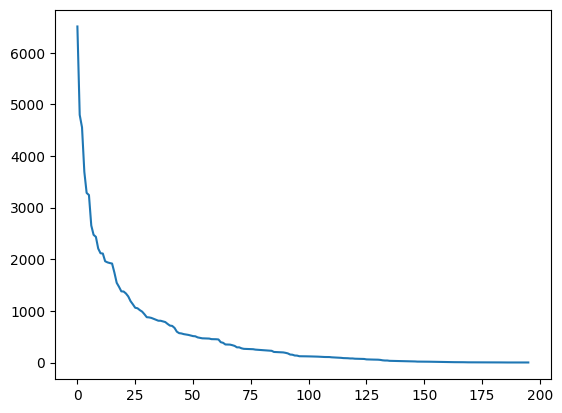

In [21]:
plt.plot(data.model.value_counts().sort_values(ascending=False).values)